In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [19]:
correlation_dir = "/mnt/c/Users/donna/Downloads/Thesis/correlation_results/heat/common"

In [20]:
files = [f for f in os.listdir(correlation_dir) if f.endswith(".csv")]

In [21]:
atac_tissues = set()
scrna_tissues = set()

In [22]:
for f in files:
    name = f.replace(".csv", "")
    parts = name.split("_")

    if len(parts) == 2:
        atac, scrna = parts
    elif len(parts) == 3:
        if parts[0] == "small":
            atac = "small_intestine"
            scrna = parts[2]
        else:
            atac = parts[0]
            scrna = "small_intestine"
    elif len(parts) == 4:
        atac = "small_intestine"
        scrna = "small_intestine"

    atac_tissues.add(atac)
    scrna_tissues.add(scrna)

In [23]:
atac_tissues = sorted(atac_tissues)
scrna_tissues = sorted(scrna_tissues)

In [ ]:
heatmap_matrix = pd.DataFrame(index=atac_tissues, columns=scrna_tissues, dtype=float)
matching_cells = 0
for f in files:
    name = f.replace(".csv", "")
    parts = name.split("_")

    if len(parts) == 2:
        atac, scrna = parts
    elif len(parts) == 3:
        if parts[0] == "small":
            atac = "small_intestine"
            scrna = parts[2]
        else:
            atac = parts[0]
            scrna = "small_intestine"
    elif len(parts) == 4:
        atac = "small_intestine"
        scrna = "small_intestine"

    corr_path = os.path.join(correlation_dir, f)
    corr_df = pd.read_csv(corr_path, index_col=0)
    matching_cells += corr_df.shape[1]

    r_vals = np.abs(corr_df.values)  
    z_vals = 0.5 * np.log((1 + r_vals) / (1 - r_vals))  # Fisher transform
    mean_z = np.mean(z_vals)  # average of z‐scores
    mean_corr = (np.exp(2 * mean_z) - 1) / (np.exp(2 * mean_z) + 1)  # back‐transform
    
    heatmap_matrix.loc[atac, scrna] = mean_corr


In [27]:
import os
import numpy as np
import pandas as pd

# pick one file to inspect
f = files[0]
corr_df = pd.read_csv(os.path.join(correlation_dir, f), index_col=0)

# absolute correlations
r = np.abs(corr_df.values)

# 1) direct mean of |r|
direct_mean = r.mean()

# 2) Fisher transform, mean, back‐transform
#    note: atanh(r) == 0.5*ln((1+r)/(1-r)), and tanh(mean_z) == back‐transform
z = np.arctanh(r)
fisher_mean = np.tanh(z.mean())

print(f"direct_mean    = {direct_mean:.12f}")
print(f"fisher_mean    = {fisher_mean:.12f}")
print(f"difference     = {(fisher_mean - direct_mean):.12f}")


direct_mean    = 0.006299716574
fisher_mean    = 0.006299862448
difference     = 0.000000145875


In [25]:
matching_cells

81

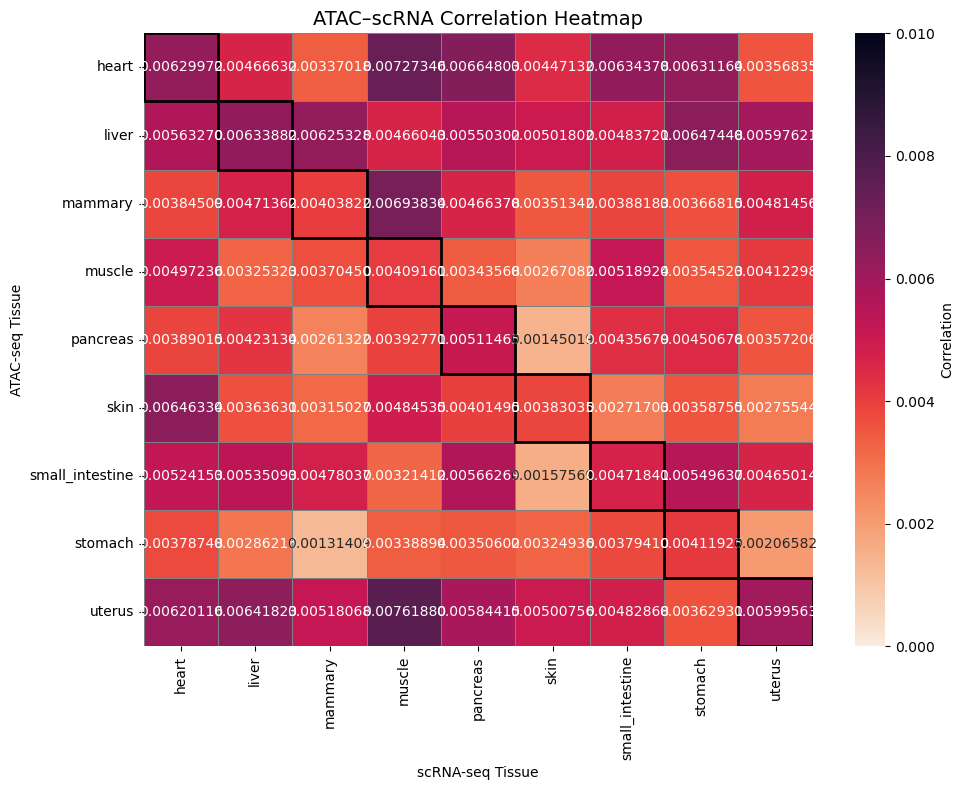

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (10, 8)
plt.figure(figsize=figsize)
ax = sns.heatmap(
    heatmap_matrix.astype(float),    # Fisher‐transformed means
    cmap="rocket_r",
    vmin=0,
    vmax=0.01,
    annot=True,
    fmt=".8f",                        # eight decimal places
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Correlation'}
)

# re‐draw the diagonal highlight
for i, tissue in enumerate(atac_tissues):
    if tissue in scrna_tissues:
        j = scrna_tissues.index(tissue)
        ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                   fill=False,
                                   edgecolor='black',
                                   lw=2))

plt.title("ATAC–scRNA Correlation Heatmap", fontsize=14)
plt.xlabel("scRNA-seq Tissue")
plt.ylabel("ATAC-seq Tissue")
plt.tight_layout()
# plt.savefig("/mnt/c/Users/donna/Downloads/Thesis/data_analysis/plots/finals/heatmap.png",
#             dpi=600, bbox_inches='tight')
plt.show()
